# Cells Dataset Preprocessing

We will do some basic QC, based on the pages on the [Seurat manual](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html#standard-pre-processing-workflow-1). This filters out cells with less than 200 or greater than 2500 unique features. Here, we'll just filter out cells with less than 200.

In [15]:
!python -m pip install git+https://github.com/myfatemi04/omicsio

  Cloning https://github.com/myfatemi04/omicsio to /scratch/pip-req-build-6h0ycfpu
  Running command git clone --quiet https://github.com/myfatemi04/omicsio /scratch/pip-req-build-6h0ycfpu
  Resolved https://github.com/myfatemi04/omicsio to commit 69a06747bf1f3e3e8475197afb64fd791f74d762
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [18]:
import omicsio

/dartfs-hpc/rc/home/x/f006jnx/anaconda3/envs/pyg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
root = "./input_data/all_single_cell_data/colon"

def filter_spot_counts(spot_counts, min_unique_genes=200):
    unique_genes_per_cell = (spot_counts > 0).sum(dim=-1)
    return spot_counts[unique_genes_per_cell >= 200]

def create_cache():
    sc1 = omicsio.datasets.load_single_cell_from_folder(root + "/DH_feb_23/SP18_56_A19")
    sc2 = omicsio.datasets.load_single_cell_from_folder(root + "/DH_feb_23/SP18_16438_A3")

    sc1.save(root + "/DH_feb_23/SP18_56_A19_raw_cached.pkl")
    sc2.save(root + "/DH_feb_23/SP18_16438_A3_raw_cached.pkl")
    
    print("Initial # of cells:")
    print(" - Slide 1:", sc1.spot_counts.shape[0])
    print(" - Slide 2:", sc2.spot_counts.shape[0])

    sc1.spot_counts = filter_spot_counts(sc1.spot_counts)
    sc2.spot_counts = filter_spot_counts(sc2.spot_counts)

    # These were ~50 less than the initial (which were 11220 and 16385)
    print("Final # of cells:")
    print(" - Slide 1:", sc1.spot_counts.shape[0])
    print(" - Slide 2:", sc2.spot_counts.shape[0])

    sc1.save(root + "/DH_feb_23/SP18_56_A19_preprocessed_cached.pkl")
    sc2.save(root + "/DH_feb_23/SP18_16438_A3_preprocessed_cached.pkl")

In [19]:
create_cache()

Initial # of cells:
 - Slide 1: 11220
 - Slide 2: 16385
Final # of cells:
 - Slide 1: 11206
 - Slide 2: 16354


In [21]:
import pickle

with open(root + "/DH_feb_23/SP18_56_A19_preprocessed_cached.pkl", "rb") as f:
    sc1 = pickle.load(f)

with open(root + "/DH_feb_23/SP18_16438_A3_preprocessed_cached.pkl", "rb") as f:
    sc2 = pickle.load(f)

## Some quick data analysis

Here, just looking for outliers, bimodal distributions, etc. Seeing if there is anything abnormal that should be filtered out.

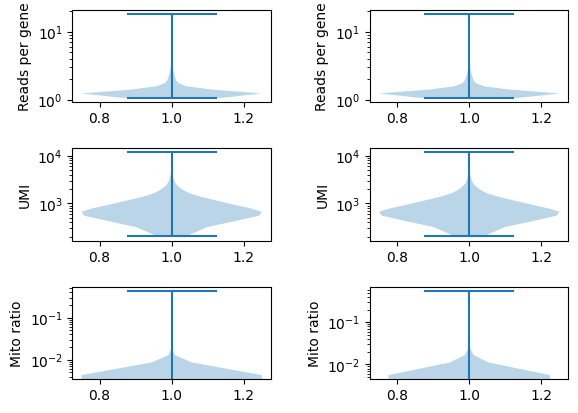

In [46]:
import matplotlib.pyplot as plt

def get_mito_ratios(slide):
    mito_genes = [i for i, gene in enumerate(sc1.genes) if gene.startswith("MT-")]
    mito_ratios = slide.spot_counts[:, mito_genes].sum(dim=-1) / slide.spot_counts.sum(dim=-1)
    return mito_ratios

def display_plots(slide, i=0):
    mito_ratios = get_mito_ratios(slide)
    total_molecules = sc1.spot_counts.sum(dim=-1)
    unique_genes = (sc1.spot_counts > 0).sum(dim=-1)
    reads_per_molecule = total_molecules / (unique_genes + 1e-9)
    
    plt.subplot(3, 2, 1 + i)
    plt.ylabel("Reads per gene")
    plt.yscale("log")
    plt.violinplot(reads_per_molecule)

    plt.subplot(3, 2, 3 + i)
    plt.ylabel("UMI")
    plt.yscale("log")
    plt.violinplot(unique_genes) # ['SP18_56_A19', 'SP18_16438_A3'])

    plt.subplot(3, 2, 5 + i)
    plt.ylabel("Mito ratio")
    plt.yscale("log")
    plt.violinplot(mito_ratios)
    
plt.subplots_adjust(hspace=0.5, wspace=0.5)

display_plots(sc1)
display_plots(sc2, 1)

plt.show()

## Preparing datasets to improve cell graph experiments

This is sort of an experimental approach, but I'm using [FAISS](https://github.com/facebookresearch/faiss), a library designed for efficient vector search. We can think of the gene expression of each cell as a vector; therefore, if a machine learning model predicts bulk RNA as the sum of several cell RNA expressions, we want to be able to deconvolve the predictions of each individual cells. This might be greatly improved through graph convolutions; however, these run the risk of individual cell predictions not resembling what the gene expression for individual cells actually looks like. By creating this index, we can train an algorithm that not only improves the accuracy of the sum gene expression, but also makes the predictions for each individual cell more closely resemble scRNA-seq signatures.

TL;DR: In creating a model to predict RNA expression for each cell, we want them to resemble scRNA-seq. A FAISS index makes it easy to nudge cell-level predictions towards realistic gene expressions

I'll sort of be following code from [this tutorial](https://www.pinecone.io/learn/faiss-tutorial/).

In [22]:
import faiss

In [24]:
def create_index(spot_counts):
    ndim = spot_counts.shape[1]
    index = faiss.IndexFlatL2(ndim)
    log_spot_counts = spot_counts.log1p()
    index.add(log_spot_counts.numpy())
    return index

index1 = create_index(sc1.spot_counts)
index2 = create_index(sc2.spot_counts)

# Now, we can use this like:

